In [1]:
#%pip install --force-reinstall pytesseract

  Using cached pytesseract-0.3.10-py3-none-any.whl (14 kB)
  Using cached Pillow-9.5.0-cp310-cp310-win_amd64.whl (2.5 MB)
  Using cached packaging-23.1-py3-none-any.whl (48 kB)
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.3.0
    Uninstalling Pillow-9.3.0:
      Successfully uninstalled Pillow-9.3.0
  Attempting uninstall: packaging
    Found existing installation: packaging 23.1
    Uninstalling packaging-23.1:
      Successfully uninstalled packaging-23.1
  Attempting uninstall: pytesseract
    Found existing installation: pytesseract 0.3.10
    Uninstalling pytesseract-0.3.10:
      Successfully uninstalled pytesseract-0.3.10
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.1 which is incompatible.

[notice] A new release of pip available: 22.3.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from mss import mss
import pydirectinput
import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
import time
from gym import Env
from gym.spaces import Box, Discrete

In [50]:
class WebGame(Env):
    def __init__(self):
        super().__init__()
        self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.int8)
        self.action_space = Discrete(3)
        
        self.cap = mss()
        self.game_location = {'top': 300, 'left': 0, 'width': 600, 'height': 500}
        self.done_location = {'top': 385, 'left': 630, 'width': 660, 'height': 70}
        
        pass
    
    def step(self, action):
        action_map = {
            0:'space',
            1:'down',
            2:'no_op'
        }
        if action != 2:
            pydirectinput.press(action_map[action])
            
        done, done_cap = self.get_done()
        new_observation = self.get_observation()
        reward = 1 
        info = {}
        
        return new_observation, reward, done, info
    
    def reset(self):
        pass
    
    def close(self):
        pass
    
    def render(self):
        pass
    
    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3]
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100, 83))
        channel = np.reshape(resized, (1,83, 100))
        
        return channel
    
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))[:,:,:3]
        done = False
        done_strings = ['GAME', 'GAHE', 'GAKN', 'GA E']
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
        
        return done, done_cap

In [51]:
env = WebGame()

In [52]:
env.action_space.sample()

2

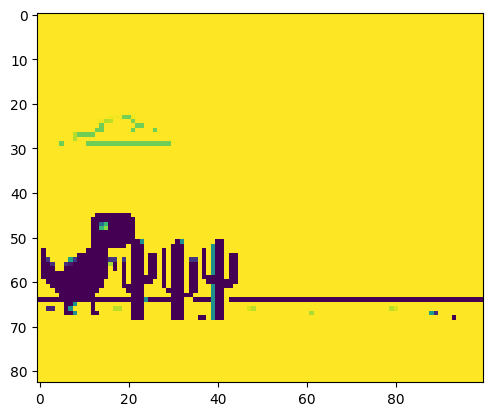

In [62]:
plt.imshow(env.get_observation()[0])

In [63]:
res, done, done_cap = env.get_done()
res

'GAME'

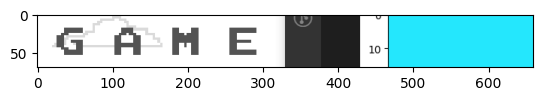

In [64]:
plt.imshow(done_cap)